In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
import pickle
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score,precision_score

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df=pd.read_csv('fake_reviews.csv')

df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [4]:
df.drop(columns = {'category'}, inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  40432 non-null  float64
 1   label   40432 non-null  object 
 2   text_   40432 non-null  object 
dtypes: float64(1), object(2)
memory usage: 947.8+ KB


In [6]:
df.rename(columns = {'text_': 'text'}, inplace = True)

In [7]:
df.head()

,rating,label,text
0,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,5.0,CG,"love it, a great upgrade from the original. I..."
2,5.0,CG,This pillow saved my back. I love the look and...
3,1.0,CG,"Missing information on how to use it, but it i..."
4,5.0,CG,Very nice set. Good quality. We have had the s...


In [8]:
def encode_label(df):
    labels = {
        'CG': 0,
        'OR': 1
    }
    
    df['target'] = df['label'].map(labels)
    
    return df

In [9]:
df = encode_label(df)
df['target'] = df['target'].fillna(0).replace([np.inf, -np.inf], 0)
df['target'] = df['target'].astype(int)
df.head()

,rating,label,text,target
0,5.0,CG,"Love this! Well made, sturdy, and very comfor...",0
1,5.0,CG,"love it, a great upgrade from the original. I...",0
2,5.0,CG,This pillow saved my back. I love the look and...,0
3,1.0,CG,"Missing information on how to use it, but it i...",0
4,5.0,CG,Very nice set. Good quality. We have had the s...,0


In [10]:
df.drop(columns = {'rating', 'label'}, inplace = True)

In [11]:
df = df.sample(frac=1).reset_index(drop=True)

df.sample(10)

,text,target
24029,"Feel apart very quickly after using it, the on...",0
27393,I need part three like this. The story is just...,0
20896,"There was potential here, but it was too short...",0
18690,was skeptical as it looked like a suction cup....,0
6786,This was an illuminating biography of a real b...,1
25981,Little smaller than I anticipated but it is pe...,1
21242,I did purchase elsewhere due to the large size...,0
14667,It's being used as I write this review I am a ...,1
32575,This knife is bulky and heavy and not in a goo...,1
18587,Yep. Perfect.\nWe've had other ones that have ...,0


In [12]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [13]:
df.duplicated().sum()

np.int64(20)

In [14]:
df.drop_duplicates(inplace = True)

In [15]:
df.duplicated().sum()

np.int64(0)

In [16]:
df['target'].value_counts()

target
1    20215
0    20197
Name: count, dtype: int64

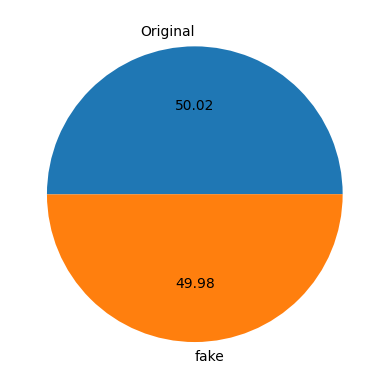

In [17]:
plt.pie(df['target'].value_counts(), labels=['Original', 'fake'],autopct="%0.2f")
plt.show()

In [18]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [19]:
df.head()

,text,target,num_characters,num_words,num_sentences
0,"The book is called a ""Corduroy"" - a book that ...",0,402,93,5
1,This Martha Stewart pom-pom flower pot. It's ...,0,1272,270,15
2,Rosemary Sutcliff is expert at what she calls ...,0,1656,300,20
3,These socks are so darn cute. The only problem...,0,267,71,6
4,"Solved the problems of all those little ""trans...",1,144,30,2


In [20]:
df.describe()

,target,num_characters,num_words,num_sentences
count,40412.000000,40412.000000,40412.000000,40412.000000
mean,0.500223,351.365337,76.691131,5.277071
std,0.500006,369.871842,79.242859,4.915033
min,0.000000,24.000000,2.000000,1.000000
25%,0.000000,107.000000,24.000000,2.000000
50%,1.000000,198.000000,44.000000,3.000000
75%,1.000000,439.000000,96.000000,6.000000
max,1.000000,2827.000000,510.000000,133.000000


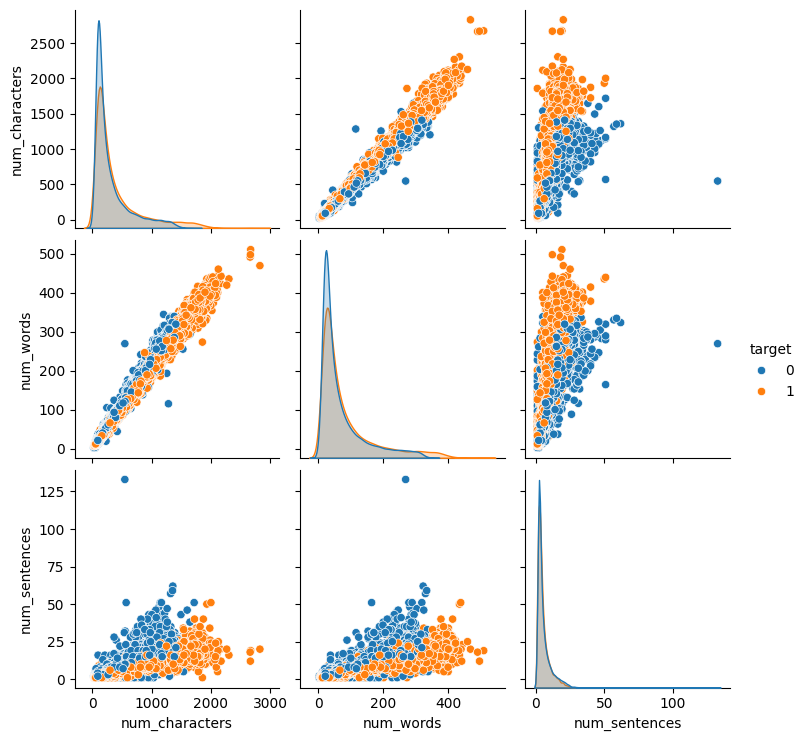

In [21]:
sns.pairplot(df,hue='target')

<Axes: >

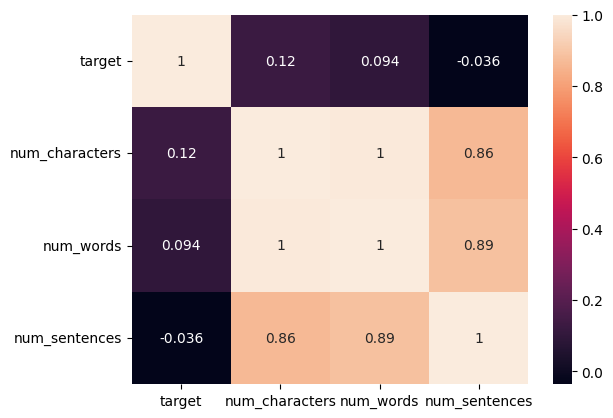

In [22]:
df_numeric = df.select_dtypes(include = 'number')
sns.heatmap(df_numeric.corr(),annot=True)

In [23]:
ps = PorterStemmer()

In [24]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [25]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [26]:
df['transformed_text'] = df['text'].apply(transform_text)

In [27]:
df.head()

,text,target,num_characters,num_words,num_sentences,transformed_text
0,"The book is called a ""Corduroy"" - a book that ...",0,402,93,5,book call corduroy book coupl peopl includ mai...
1,This Martha Stewart pom-pom flower pot. It's ...,0,1272,270,15,martha stewart flower pot good size look great...
2,Rosemary Sutcliff is expert at what she calls ...,0,1656,300,20,rosemari sutcliff expert call hidden histori a...
3,These socks are so darn cute. The only problem...,0,267,71,6,sock darn cute problem kind small 6 5 wear 32d...
4,"Solved the problems of all those little ""trans...",1,144,30,2,solv problem littl transform plug seem everyth...


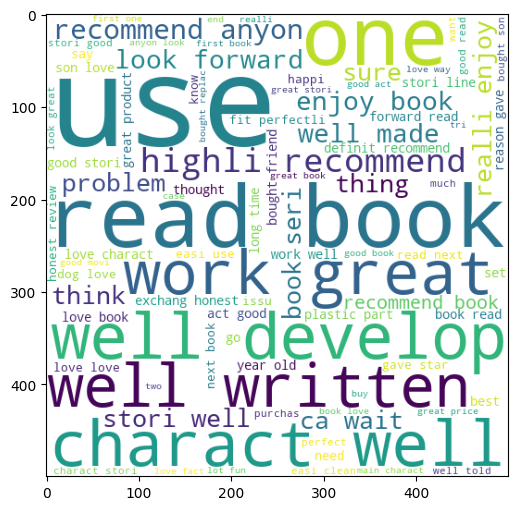

In [28]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
fake_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(fake_wc)

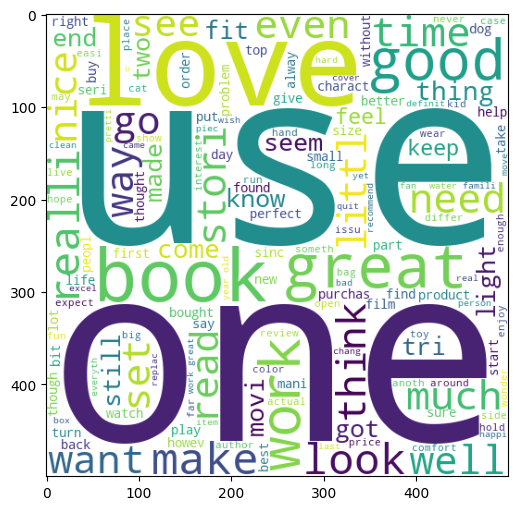

In [29]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
original_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(original_wc)

In [30]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [31]:
print(X.shape)
print(y.shape)

(40412, 3000)
(40412,)


In [32]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=32)

In [33]:
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [34]:
clfs = {
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'xgb':xgb
}

In [35]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    return accuracy,precision

In [36]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

In [37]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [38]:
performance_df.reset_index(drop = True)

,Algorithm,Accuracy,Precision
0,LR,0.861809,0.861946
1,NB,0.837065,0.838328
2,RF,0.833230,0.836428
3,xgb,0.823952,0.824081
4,AdaBoost,0.692565,0.694653
5,DT,0.592602,0.643534
6,KN,0.501175,0.608447


In [39]:
mnb = MultinomialNB()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [40]:
voting = VotingClassifier(estimators=[('LR', lrc), ('nb', mnb), ('RF', rfc)],voting='soft')

In [41]:
voting.fit(X_train,y_train)

,estimators,"[('LR', ...), ('nb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [42]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.8693554373376222
Precision 0.8848500254194205


In [43]:
estimators = [('LR', lrc), ('nb', mnb), ('RF', rfc)]
final_estimator = RandomForestClassifier(n_estimators=50, random_state=2)

In [44]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [45]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.8579735246814302
Precision 0.8701462430660615


In [46]:
pickle.dump(tfidf, open("D:/Aswin/Data Science/ML project/Fake-Review-Prediction/app/models/vectorizer.pkl", 'wb'))
pickle.dump(voting, open("D:/Aswin/Data Science/ML project/Fake-Review-Prediction/app/models/model.pkl", 'wb'))

In [53]:
sen=['This is a great good product']
sem=tfidf.transform(sen)
pred1=(voting.predict(sem))
print(pred1)
if pred1==0:
    print('Fake or Computer Generated')
else:
    print("genuine or Original")
voting.predict_proba(sem)

[0]
Fake or Computer Generated


array([[0.75357934, 0.24642066]])

In [48]:
print(voting.classes_)

[0 1]
